In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate 

def MakeHankelMatrix(X, s):
    '''Turn data matrix into hankel matrix with time delay coordinates, implementation taken from https://stackoverflow.com/questions/71410927/vectorized-way-to-construct-a-block-hankel-matrix-in-numpy-or-scipy '''
    d = s+1
    n, N = X.shape
    if s > 0:
        return np.lib.stride_tricks.sliding_window_view(X, (n, N+1-d)).reshape(d*n, -1)
    else:
        return X
    
def linearSys(N, x0):
    '''Return data for N instances of linear system evolution'''
    # A = np.array([[-0.99, -2, 3, 1], [0, 0.95, -1, 0.8], [0, 0, 0.96, -0.7], [0, 0, 0, -0.99]])/1.05
    Auns = np.array([[1, 2, 3], [2, 4, 5], [1, 8, 1]])
    A = scipy.linalg.expm(- Auns @ Auns.transpose() * 0.01)
    
    C = np.zeros((1,3))
    C[0,0] = 1.0
    # C[1,1] = 1.0
    
    x = np.empty((3, N+1))
    x[:,0] = x0.flatten()
    y = np.empty((1, N+1))
    y[:,0] = (C @ x0).flatten()
    
    for i in range(N):
        x[:,i+1] = A @ x[:,i]
        y[:,i+1] = C @ x[:,i+1]
        
        
    # print(np.linalg.matrix_rank(control.obsv(A, C)))
    print(np.linalg.eigvals(A))
    return x

def linearSys_ODEsolver(N, x0):
    Auns = np.array([[1, 2, 3], [2, 4, 5], [1, 8, 1]])
    A = - Auns @ Auns.transpose()
    T_final = (N-1) * 0.1
    t = np.linspace(0, T_final, N)
    
    ode_fun = lambda t,x: A @ x
    
    y = scipy.integrate.solve_ivp(ode_fun, [0, T_final], x0, t_eval=t).y
    return y

[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[0.3450186  0.9998178  0.83055524]
[ 9.99817805e-01+0.00000000e+00j  8.30555243e-01+0.00000000e+00j
  3.45018599e-01+0.00000000e+00j -2.44346476e-16+1.57453635e-16j
 -2.44346476e-16-1.57453635e-16j]
[ 0.9998178   0.83055524  0.3450186  -0.56771689]


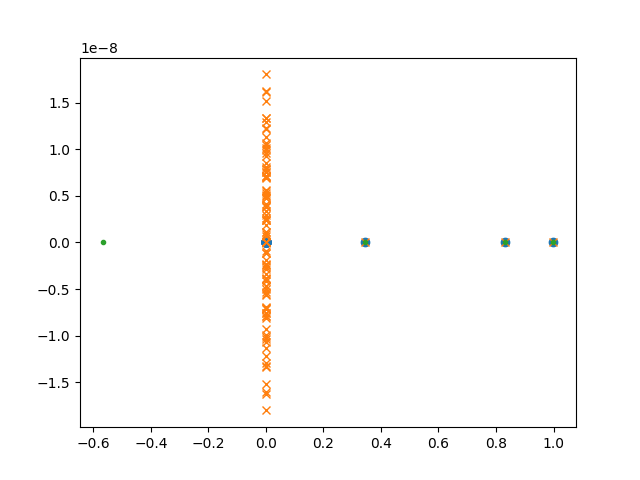

In [70]:
import scipy.linalg
# np.random.seed(123)
# Initialise
N = 15                             # Number of rows of measurement data Y, i.e. measurement sequence length
N_t = 10                           # Number of columns of measurement data Y, i.e. number of measurement sequences
N_g = 2                            # Used to construct measurement data Y
n = 3
G = np.random.rand(N_g, N_t)

# Define Y as decomposed product of a VanderMonde matrix and random initial states.
# Y = np.vander([0.9, 0.95, 0.98], N, increasing=True).T @ np.random.rand(N_g, N_t) 
# Alternative for if eigenvalues on unit circle
# Y = np.vander([0.8, -0.9], N, increasing=True).T @ G
s = 5
# ic = randomCirc(


X_lin = np.empty((N_t, n, N))
Y = np.empty((s+1, N-s, N_t))
for i in range(N_t):
    # X[:,i] = linearSys(N-1, np.array([0.5, i, 1, 2]))
    Seq = linearSys(N-1, randomCirc(1, 3).flatten()) #np.array([0.5, i, 1]))
    X_lin[i,:,:] = Seq
    # print(Seq)
    Y[...,i] = MakeHankelMatrix(X_lin[i,0,:].reshape((1,N)), s)
    
    # print(Y[...,i])

# Y = MakeHankelMatrix(X.T, s)

# Xp = X[:N//2,:]
# Xf = X[N//2:,:]

# G = Xf @ Xp.T @ np.linalg.inv(Xp @ Xp.T)

# U,_,_ = np.linalg.svd(G, full_matrices = True)

# W = U[:, :8]

N_t_lin = N_t

Z = Y.reshape((s+1,-1), order='F')
# print(Y)
# print(Z)
# x = np.reshape(X[:-1, 0], (N-1, 1))
# y = np.reshape(X[1:, 0] , (N-1, 1))

# X_data = MakeHankelMatrix(x.T, 15)
# Y_data = MakeHankelMatrix(y.T, 15)

# Rxx = X_data @ X_data.T
# Rxy = X_data @ Y_data.T


# e, v = scipy.linalg.eig(Rxx, Rxy)
# print(1/e)

# Conclusion: Only works if eigenvalues are on the unit circle

# Generalised ESPRIT method
X_data = Z[:-1,:]
Y_data = Z[1:,:]

Phi = np.linalg.pinv(X_data) @ Y_data
Phi2 = np.linalg.pinv(Z[:-2,:]) @ Z[2:,:]
E = np.linalg.eigvals(Phi)
E2 = np.sqrt(np.linalg.eigvals(Phi2))
plt.figure()
plt.plot(E.real, E.imag, 'o')
plt.plot(E2.real, E2.imag, 'x')
print(np.linalg.eigvals(Phi)[:5])

# Alternative through W subspace
u,s,v = np.linalg.svd(Z)

sv = np.linalg.eigvals(np.linalg.pinv(u[:-1,:4]) @ u[1:,:4])
plt.plot(sv.real, sv.imag, '.')
print(sv)
# M_d, N_d = X_data.shape

# Rng = 140
# sv = np.empty((Rng, min(M_d, N_d)))
# for lm in range(Rng):
#     # sv[lm] = np.linalg.norm(Y_data - (2.0 * lm - Rng)/Rng * X_data, 'nuc')
#     sv[lm,:] = np.linalg.svd(Y_data - (2.2 * lm - Rng) / Rng * X_data, compute_uv=False)
#     # sv[lm,:] = np.linalg.det(Y_data.T @ Y_data - (2.2 * lm - Rng) / Rng * np.eye(100)) # X_data.T @ X_data)
#      # = s

# s2 = np.linalg.svd(Y_data, compute_uv=False)
# print(s2)
# plt.plot(2.2*np.arange(Rng)/Rng - 1, sv / np.max(sv, axis=0).reshape((min(M_d,N_d),1)).T, '--')
# plt.ylim([0,0.5])

# Generalised eigenvalues instead
# print(scipy.linalg.eigvals(X_data, Y_data))

[[[ 0.86997653]
  [-0.78733486]
  [ 0.97070801]
  [-0.28244699]]

 [[ 0.33140692]
  [-0.52186494]
  [-0.16025862]
  [-0.09937437]]]
[[1.66525004 1.96261111 1.7040865  2.14500392 2.42733481 1.94108857
  1.21895572 1.32590549 2.0558468  2.22895334 1.90891295 1.60588797
  2.3702315  0.58925917 2.3196161  1.54089947 2.44430642 1.3465901
  1.93670546 2.43894563 1.91243882 1.23282165 1.99344421 1.6816015
  2.59522984 1.09032896 1.84553365 1.94401794 2.04977492 1.63097749
  1.99952676 2.56337647 1.62198803 2.02102506 2.23460552 1.33017092
  1.6767837  1.49854687 2.37165796 1.59766673 0.26958275 1.6190344
  1.80329067 1.80046393 1.7050306  1.64113158 2.04230584 2.77157395
  2.15210547 1.61847009 1.67822271 2.27015665 1.02590518 1.82113468
  0.90222735 2.23883971 1.9895251  1.72999077 2.4463359  2.46605439
  1.43554186 1.77025211 1.48939569 1.7633513  1.63425142 1.83721525
  1.15717301 1.09282197 0.84770783 1.5625899  2.09287282 2.25164665
  2.9644754  1.58515912 1.72441866 2.27899443 1.6325170

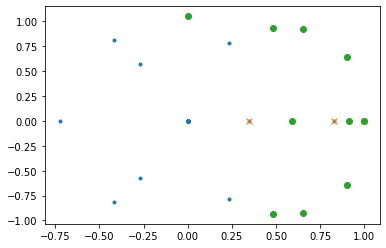

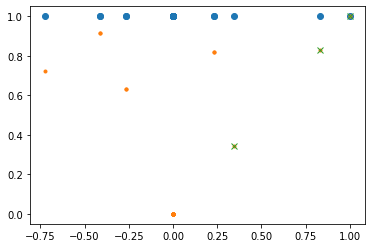

In [4]:
%reload_ext autoreload
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

import System
import methods
import numpy as np
import Dictionaries
import utils
import matplotlib.pyplot as plt
import scipy.linalg


def randomCirc(N, n, r = 2):
    '''Construct N initial conditions for random points on an n-d sphere of radius r'''
    # Normalised n-d Gaussian points result in a uniform point on a sphere
    
    random_Initialconditions = np.random.randn(N,n)
    return r * random_Initialconditions / np.linalg.norm(random_Initialconditions, axis=1).reshape((N,1))


KordaEquation = System.differentialEquation(System.LinearSystem, 3, 1)

# print(System.LinearSystem(1, np.array([1,2,3]), np.array([0])))
                    
Korda = System.System(KordaEquation, '../testdata/Linear.mat', 50, 20, 0.01, Generate=True, Autonomous=True, Initialisation_function = randomCirc)

A = np.array([[1, 2, 3], [2, 4, 5], [1, 8, 1]])
Astable = - A @ A.transpose()
e,_ = np.linalg.eig(scipy.linalg.expm(Astable * 0.01) )
print(e)

X = Korda.trainingData()

print(X.shape)

N_t, n, N = X.shape
s = 10

N = 30
Y = np.empty((s+1, N-s, N_t))
for i in range(N_t):
    # print(f'Trajectory {i}')
    Y[:,:,i] = utils.MakeHankelMatrix(X[i,0,:N].reshape((1,N)), s)

H = Y.reshape((s+1,-1), order='F')

# Y = np.empty((s+1, N- s -1, N_t))
# for i in range(50):
    # Turn each trajectory sequence into time-delay matrix of format n x s x N
    # Y = utils.MakeHankelMatrix(X[0,:,i], 10)

# Reshape Y into format 
# Stack Hankel matrices horizontally
# H = np.transpose(Y, [1, 2, 0]).reshape(
# print(H)

Phi = np.linalg.pinv(H[:-1,:]) @ H[1:,:]
E, v = np.linalg.eig(Phi)
Phi2 = np.linalg.pinv(H[:-2,:]) @ H[2:,:]
Phi3 = np.linalg.pinv(H[:-3,:]) @ H[3:,:]
E2 = np.sqrt(np.linalg.eigvals(Phi2))
E3 = (np.linalg.eigvals(Phi3)) ** (1.0/3)

E4 = np.sqrt(scipy.linalg.eigvals( H[1:,:] @ H[1:,:].T, H[:-1, :] @ H[1:,:].T))

plt.figure()
plt.plot(E.real, E.imag, '.')
plt.plot(e.real, e.imag, 'x')
# plt.plot(E2.real, E2.imag, '.')
# plt.plot(E3.real, E3.imag, '.')
plt.plot(E4.real, E4.imag, 'o')

print(E.shape)
print(E2.shape)


print(E[:8])
plt.figure()
plt.plot(E.real, np.linalg.norm(v, axis=0), 'o')
plt.plot(E.real, abs(E), '.')
plt.plot(e.real, abs(e), 'x')


Key 'Generate' not found in system construction
Key 'Autonomous' not found in system construction
Generating new dataset
Computing linear evolution in data to find initial states on nonrecurrent set
Found eigenvalues listed below
[[ 0.99981773  0.83056686  0.34499033 -0.48851898]
 [ 0.99981804  0.8305697   0.34499032 -0.48844245]
 [ 0.83053689  0.99981528  0.34499018 -0.48773137]]
Found relative residual in x1 of 0.001 %
Found relative residual in x2 of 0.004 %
Found relative residual in x3 of 0.013 %
(0.00020658308129298253+0j)
Computed eigenfunction, eigenvalue pairs in 7.9 ms
Starting computation of linear evolution surface from data
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished interpolating
Interpolating
Finished

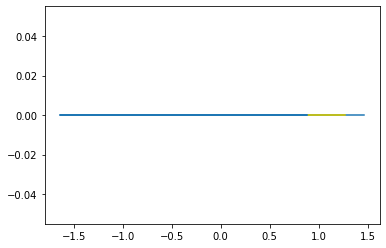

In [13]:
# Setup
KordaEquation = System.differentialEquation(System.LinearSystem, 3, 1)
Korda = System.System(KordaEquation, '../testdata/Linear.mat', 100, 30, 0.01, Generate=True, Autonomous=True, Initialisation_function = randomCirc)
f = Dictionaries.thin_plate_rbf_dictionary(3, 9, 4)
# Compute Koopman estimate
N_g = 4
A, C, f_opt = methods.compute_Korda2020(X, N_g, f)
# True eigenvalues 0.3450186  0.9998178  0.83055524

(12, 1)
(12, 12)
(3, 12)
Lifting dynamics
[[ 1.65398532e-01+0.j]
 [ 6.95618054e-02+0.j]
 [ 2.65044650e-01+0.j]
 [-1.00958122e-06+0.j]
 [-9.93866424e-02+0.j]
 [ 1.05685326e-01+0.j]
 [ 4.93710673e-01+0.j]
 [-1.89528814e-06+0.j]
 [-1.16186229e-01+0.j]
 [ 8.62166442e-03+0.j]
 [ 6.07576853e-01+0.j]
 [-2.53986111e-06+0.j]]
12
1
1


C:\Users\menno\.conda\envs\networked\lib\site-packages\scipy\signal\_ltisys.py:3491: ComplexWarning: Casting complex values to real discards the imaginary part
  xout[0, :] = np.asarray(x0)


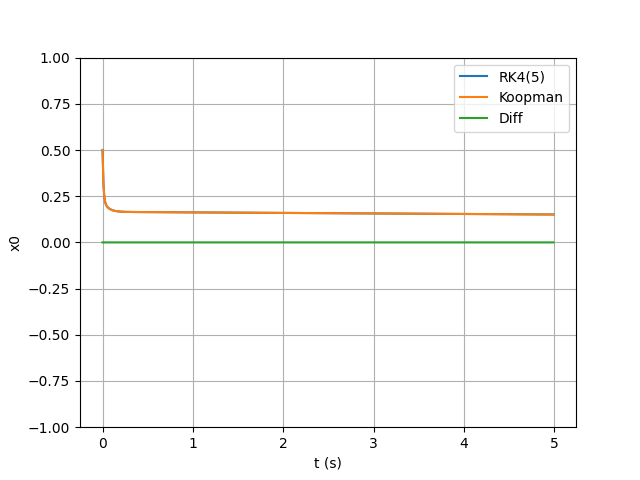

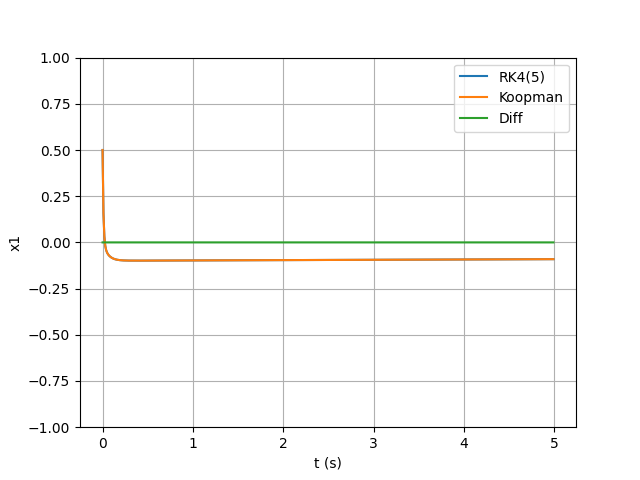

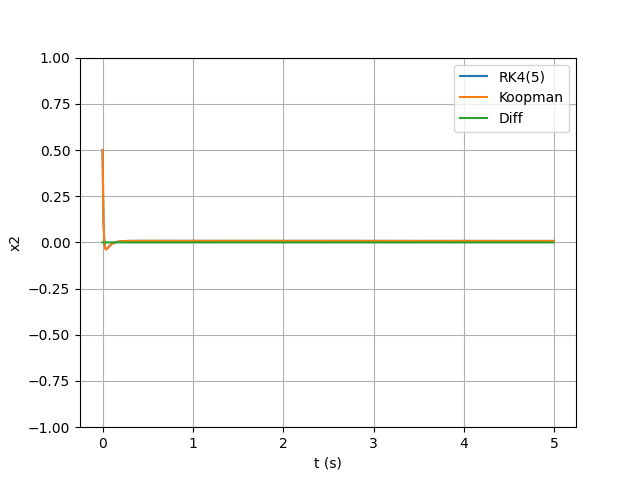

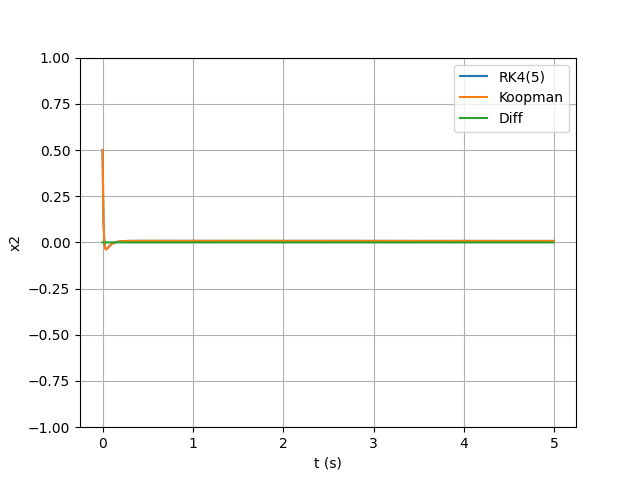

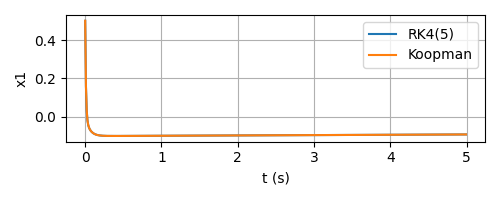

In [15]:
%matplotlib widget
import plot_data
x0 = np.array([0.5, 0.5, 0.5])
u = np.zeros((1,500))
B = np.zeros((3 * N_g, 1))
print(B.shape)
print(A.shape)
# print(A)
print(C.shape)

t_out, y_est, y_comp, y_est2 = methods.linear_compare(A, B, C, Korda, f_opt, 0, x0, u)

plot_data.compareTrajectories(t_out, y_comp, y_est2, y_comp-y_est2, Names=["RK4(5)", "Koopman", "Diff"])
plt.ylim([-1,1])

plt.figure(figsize=(5,2))
plt.plot(t_out, y_comp[1,:])
plt.plot(t_out, y_est2[1,:])
plt.legend(["RK4(5)", "Koopman"])
plt.ylabel('x1')
plt.xlabel('t (s)')
plt.grid()
plt.tight_layout()
plt.savefig("LiftedvdLinearUpdateApril.pdf")